# Postural Sway: Rambling and Trembling decomposition of the COP


> Marcos Duarte  
> Laboratory of Biomechanics and Motor Control ([http://demotu.org/](http://demotu.org/))  
> Federal University of ABC, Brazil

### First, let's import the necessary Python libraries and configure the environment

In [1]:
import sys, os
sys.path.insert(1, r'./../functions')
import numpy as np
import pandas as pd
pd.set_option('precision', 4)
# matplotlib configuration:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
sns.set_context("notebook", font_scale=1.4,
                rc={'font.size': 16, 'lines.linewidth': 2,\
                    'lines.markersize': 10, 'axes.titlesize': 'x-large'})
matplotlib.rc('legend', numpoints=1, fontsize=16)
# IPython:
from IPython.display import display, Image, IFrame
import ipywidgets
from ipywidgets import FloatProgress, interactive

### Hypothesis about the human postural control (Zatsiorsky)

The control system for equilibrium of the human body includes two subsystems:  
 1. the first one determining a reference position with respect to which the body equilibrium is maintained.  
 2. the second one maintaining equilibrium about the pre-selected reference point.

### Findings supporting a two-subsystems control

> Gurfinkel et al. (1995) Kinesthetic reference for human orthograde posture. Neuroscience, 68, 229.  

The supporting surface where the subjects stood was tilted slowly (0.04 $^o/s$).  
During the tilting, **small high frequency oscillations** of the body were superimposed on a **large slow body movements**.  
The usual process of stabilization of the body continued, but the **instant equilibrium** was maintained relative to a **slowly changing position**, rather than around a fixed set point.

> See Zatsiorsky & Duarte (2000), for a review about findings supporting a two-subsystems control.

### Force fields during quiet standing

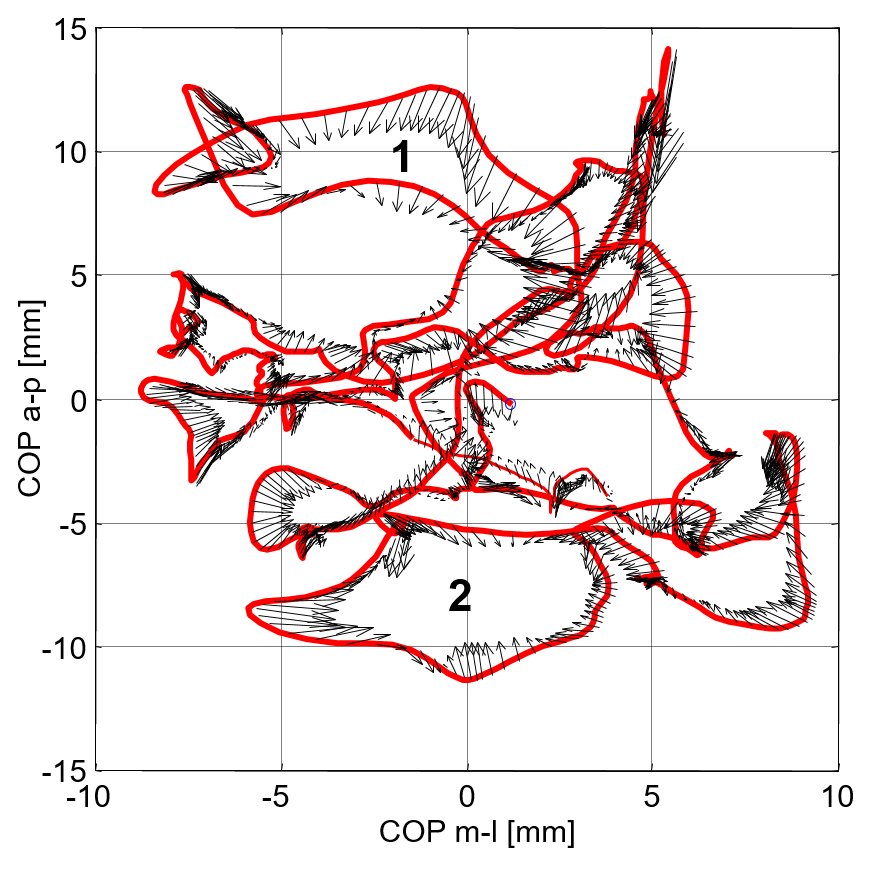

In [2]:
Image(filename='../images/forcevectors.png', width=500)

### Prolonged Standing

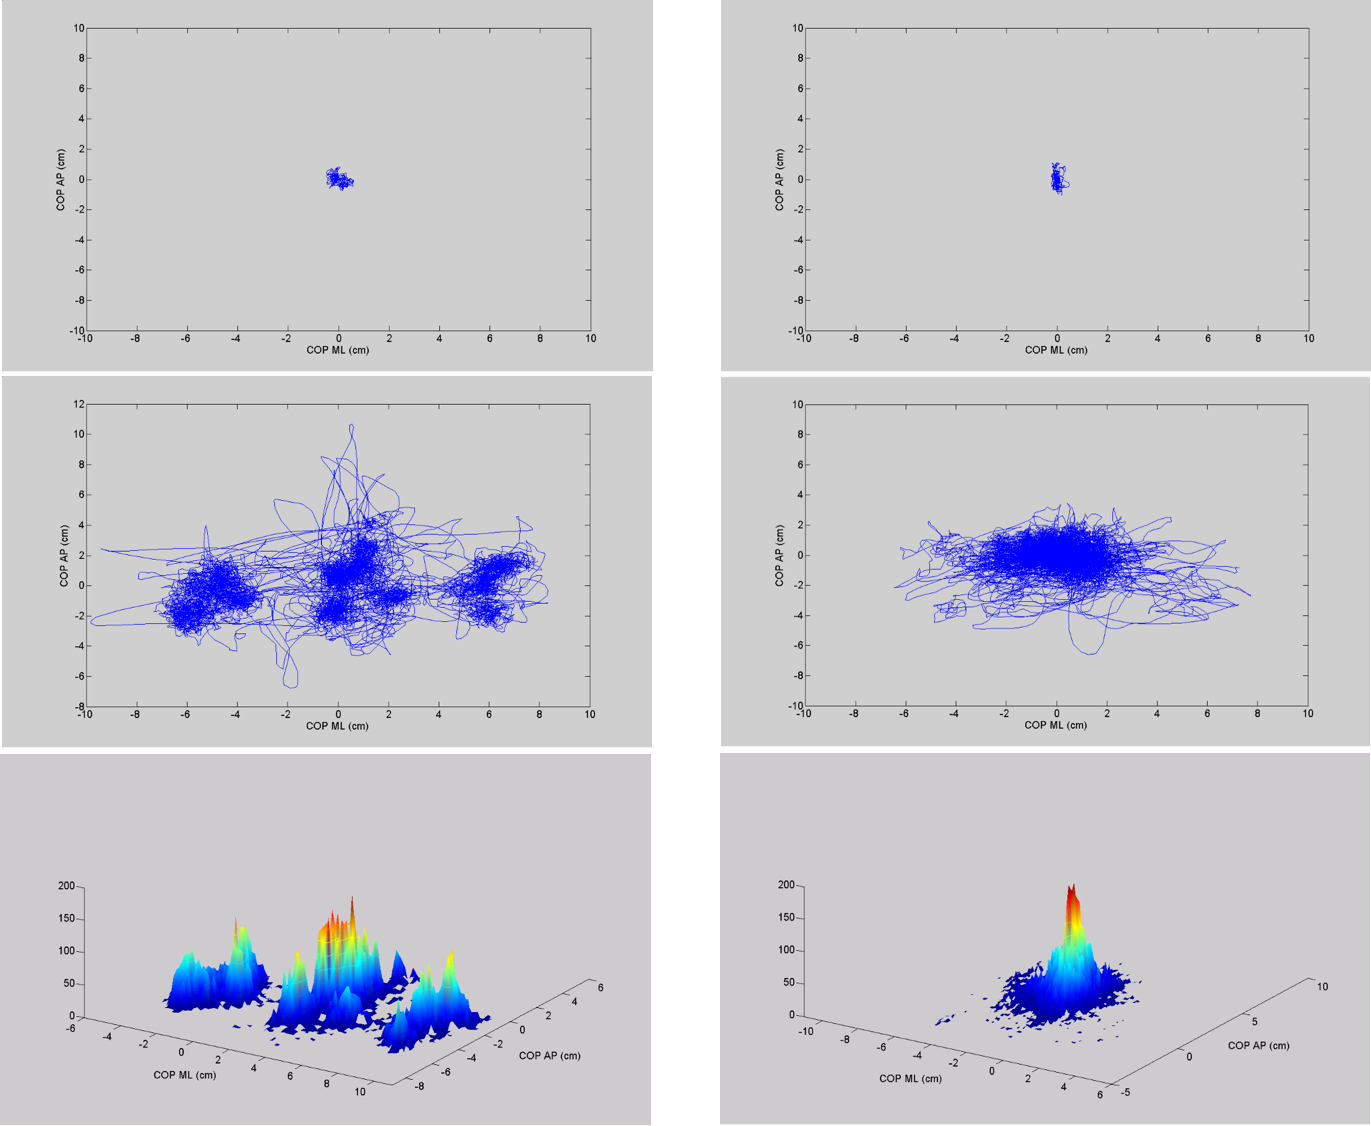

In [3]:
display(Image(filename='../images/prolongedstanding.png', width=600))

### Postural sway: a fractal process

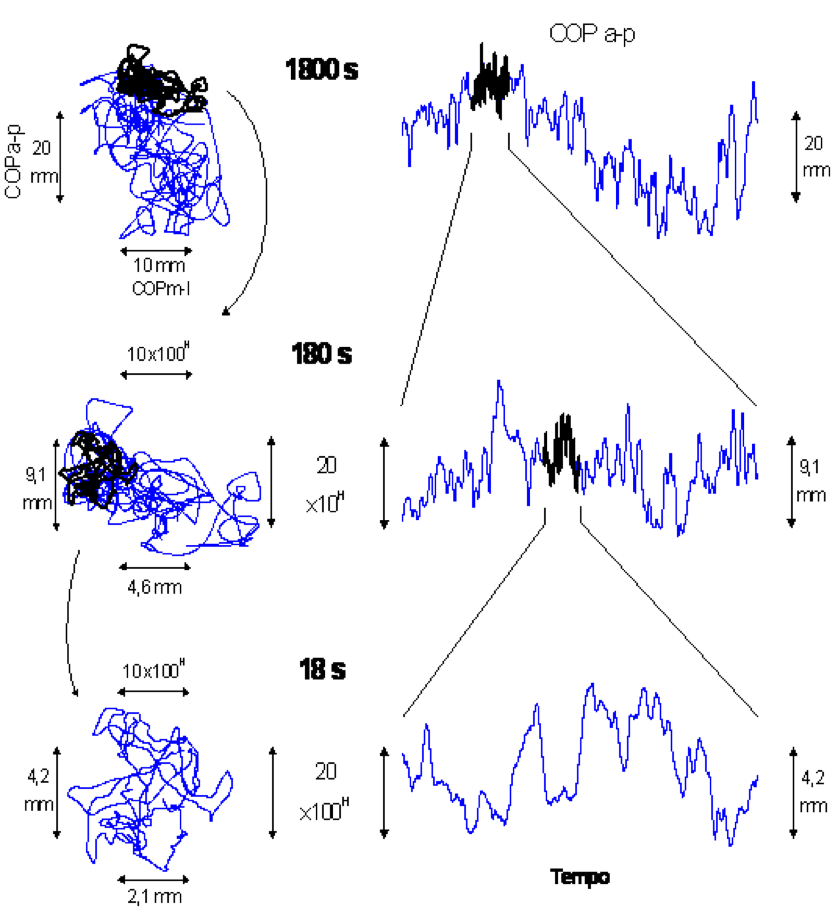

Duarte & Zatsiorsky (2000)


In [4]:
display(Image(filename='../images/fractal.png', width=500))
print('Duarte & Zatsiorsky (2000)')

### Rambling and Trembling decomposition of the COP

The reference point migration is called **rambling** and the COP migration around the reference was coined **trembling**.

- Zatsiorsky VM, Duarte M (1999) Instant equilibrium point and its migration in standing tasks: Rambling and trembling components of the stabilogram. Motor Control, 3, 28. [PDF](http://demotu.org/pubs/mc99.pdf).  
- Zatsiorsky VM, Duarte M (2000) Rambling and trembling in quiet standing. Motor Control, 2, 185. [PDF](http://demotu.org/pubs/e00.pdf).  

In [5]:
IFrame('http://demotu.org/pubs/mc99b.pdf', width='100%', height=450)   

In [6]:
IFrame('http://demotu.org/pubs/mc00.pdf', width='100%', height=450)

### Rambling and Trembling during quiet standing

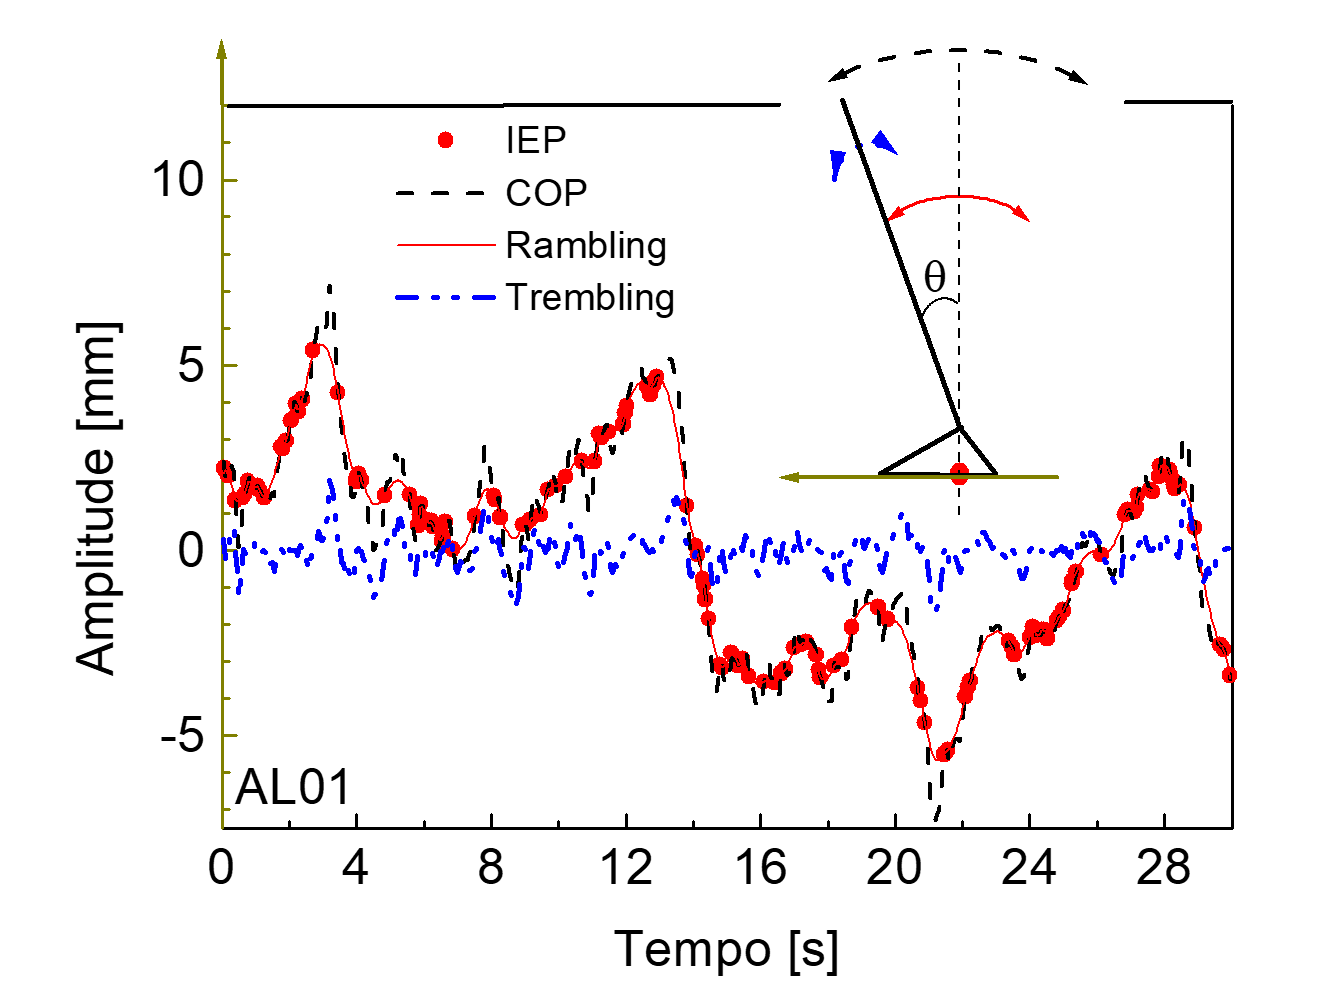

In [7]:
Image(filename='../images/rambtremb.png', width=600)

 ### Balance maintenance according to the Rambling and Trembling hypothesis
 
 1. The CNS specifies an intended position of the body. The intended position is specified by a reference point on the supporting surface with respect to which body equilibrium is instantly maintained.  
 2. The reference point migrates and can be considered a moving attracting point.  
 3. The body sways because of two reasons: the migration of the reference point and the deviation away from the reference point.  
 4. When the deflection is not too large, the restoring force is due to the ‘apparent intrinsic stiffness’ of the muscles. 

### Decomposition based on the instant-equilibrium-point hypothesis

The rambling and trembling components of the COP trajectory were computed in the following way:  
 1. The instants when $F_{hor}$ changes its sign from positive (negative) to negative (positive) are determined.  
 2. The COP positions at these instants (the instant equilibrium points, IEP, or zero-force points) are determined.  
 3. To obtain an estimate of the rambling trajectory, the IEP discrete positions are interpolated by cubic spline functions.  
 4. To obtain the trembling trajectory, the deviation of the COP from the rambling trajectory is determined.

### Some auxiliary functions

In [8]:
def detect_zerocross(y, method='no_zero'):
    """
    Zero-crossing detection, index before a zero cross.
    """

    import numpy as np
    
    y = np.asarray(y)
    
    if method == 'no_zero':
        # doesn't detect if a value is exactly zero:
        inds0 = np.where(y[:-1] * y[1:] < 0)[0]
    else:
        # detects if a value is exactly zero:
        inds0 = np.where(np.diff(np.signbit(y)))[0]  
        
    return inds0

In [9]:
def iep_decomp(time, force, cop):
    """
    Center of pressure decomposition based on the IEP hypothesis.
    """
    
    import numpy as np
    from scipy.interpolate import UnivariateSpline
    
    force = force - np.mean(force)
    
    # detect zeros
    inds0 = detect_zerocross(force)
    
    # select data between first and last zeros
    time = time[inds0[0]:inds0[-1]+1]
    force = force[inds0[0]:inds0[-1]+1]
    cop = cop[inds0[0]:inds0[-1]+1]
    
    # IEP0 & IEP:
    iep0 = inds0 - inds0[0]
    spl = UnivariateSpline(time[iep0], cop[iep0], k=3, s=0)
    rambling = spl(time)
    trembling = cop - rambling
    
    return rambling, trembling, iep0, inds0

### Load some postural sway data

In [10]:
# data available at https://doi.org/10.6084/m9.figshare.3394432.v2
# load some data
# locally:
path2 = r'./../../../X/BDB/'
filename = os.path.join(path2, 'BDS00038.txt')
grf = pd.read_csv(filename, delimiter='\t', skiprows=1, header=None,
                  names=['Time','Fx','Fy','Fz','Mx','My','Mz','COPx','COPy'],
                  engine='c')

t, Fx, Fy, Fz, Mx, My, Mz, COPx, COPy = [_ for _ in grf.values.T]

In [11]:
def plot_grf(grf):
    t, Fx, Fy, Fz, Mx, My, Mz, COPx, COPy = [_ for _ in grf.values.T]
    Funits, Munits, COPunits = 'N', 'Nm', 'cm'
    plt.figure(figsize=(12, 7))

    gs1 = gridspec.GridSpec(3, 1)
    gs1.update(bottom=0.52, top=0.96, hspace=0.12, wspace=.2)
    ax1, ax2, ax3 = plt.subplot(gs1[0]), plt.subplot(gs1[1]), plt.subplot(gs1[2])
    gs2 = gridspec.GridSpec(3, 3)
    gs2.update(bottom=0.08, top=0.42, wspace=0.3)
    ax4, ax5 = plt.subplot(gs2[:, :-1]), plt.subplot(gs2[:, 2])

    ax1.set_ylabel('Fx (%s)' %Funits)
    ax1.set_xticklabels([]), ax1.locator_params(axis='y', nbins=4)
    ax1.yaxis.set_label_coords(-.07, 0.5)
    ax2.set_ylabel('Fy (%s)' %Funits)
    ax2.set_xticklabels([]), ax2.locator_params(axis='y', nbins=4)
    ax2.yaxis.set_label_coords(-.07, 0.5)
    ax3.set_ylabel('Fz (%s)' %Funits)
    ax3.locator_params(axis='y', nbins=4)
    ax3.yaxis.set_label_coords(-.07, 0.5)
    ax3.set_xlabel('Time (s)')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('COP (%s)' %COPunits)
    ax5.set_xlabel('COPml (%s)' %COPunits)
    ax5.set_ylabel('COPap (%s)' %COPunits)

    ax1.plot(t, Fx), ax2.plot(t, Fy), ax3.plot(t, Fz)
    ax4.plot(t, COPx, 'b', label='COP ap')
    ax4.plot(t, COPy, 'r', label='COP ml')
    ax4.yaxis.set_label_coords(-.1, 0.5)
    ax4.legend(fontsize=12, loc='best', framealpha=.5)
    ax5.plot(COPy, COPx)
    ax5.locator_params(axis='both', nbins=5)
    plt.suptitle('Ground reaction force data during quiet standing', fontsize=20, y=1)
    plt.show()

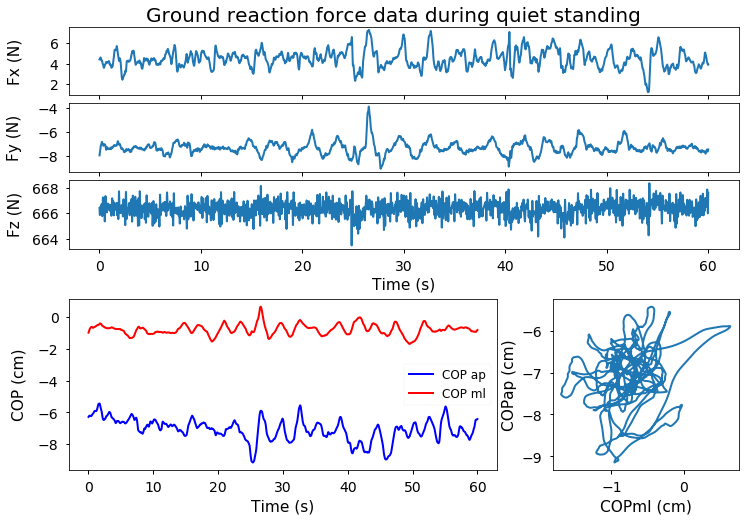

In [12]:
plot_grf(grf)

### Running the rambling-trembling decomposition

In [13]:
rambling, trembling, iep0, inds0 = iep_decomp(t, Fx, COPx)
t2 = t[inds0[0]:inds0[-1]+1]
Fx2 = Fx[inds0[0]:inds0[-1]+1] - np.mean(Fx)
COPx2 = COPx[inds0[0]:inds0[-1]+1]

In [14]:
def plot_rambtremb(t, Fx, COPx, rambling, trembling, iep0, inds0):
    Funits, Munits, COPunits = 'N', 'Nm', 'cm'
    plt.figure(figsize=(12, 6))
    gs1 = gridspec.GridSpec(4, 1)
    gs1.update(bottom=0.01, top=0.96, hspace=0.12, wspace=.15)
    ax1 = plt.subplot(gs1[0])
    ax2 = plt.subplot(gs1[1])
    ax3 = plt.subplot(gs1[2])
    ax4 = plt.subplot(gs1[3])
    
    ax1.set_ylabel('F (%s)' %Funits)
    ax1.set_xticklabels([]), ax1.locator_params(axis='y', nbins=4)
    ax1.yaxis.set_label_coords(-.05, 0.5)
    ax2.set_ylabel('COP (%s)' %COPunits)
    ax2.set_xticklabels([]), ax2.locator_params(axis='y', nbins=4)
    ax2.yaxis.set_label_coords(-.05, 0.5)
    ax3.set_ylabel('Rambling'), ax3.locator_params(axis='y', nbins=4)
    ax3.set_xticklabels([]), ax3.locator_params(axis='y', nbins=4)
    ax3.yaxis.set_label_coords(-.05, 0.5)
    ax4.set_ylabel('Trembling'), ax4.locator_params(axis='y', nbins=4)
    ax4.yaxis.set_label_coords(-.05, 0.5)
    ax4.set_xlabel('Time (s)')

    ax1.plot(t, Fx)
    ax1.plot(t[iep0], Fx[iep0], 'ro', markersize=5)
    ax2.plot(t, COPx, linewidth=3)
    ax3.plot(t, rambling, linewidth=3)
    ax3.plot(t, COPx, 'k', linewidth=.5)
    ax4.plot(t, trembling, linewidth=3)
    
    plt.suptitle('Rambling & Trembling decomposition during quiet standing', fontsize=18, y=1)

    plt.show()

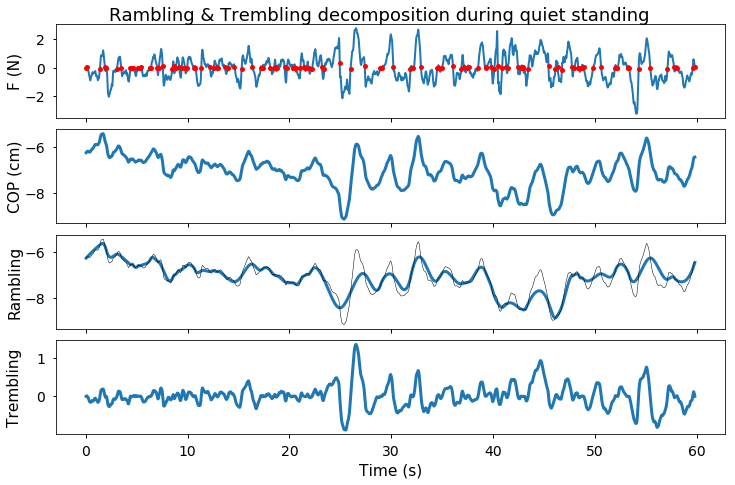

In [15]:
plot_rambtremb(t2, Fx2, COPx2, rambling, trembling, iep0, inds0)

### Let's run the rambling-trembling decomposition for a sample of subjects

> Santos DA, Duarte M. (2016) A public data set of human balance evaluations. PeerJ4:e2648 https://doi.org/10.7717/peerj.2648.

The data set comprises signals from the force platform (raw data for the force, moments of forces, and centers of pressure) of 163 subjects plus one file with information about the subjects and balance conditions and the results of the other evaluations.   

Subject’s balance was evaluated by posturography during standing still for 60 s in four different conditions where vision and the standing surface were manipulated.

In [16]:
path2 = r'./../../../X/BDB/'
fname = os.path.join(path2, 'BDSinfo.txt')
BDSinfo = pd.read_csv(fname, sep='\t', header=0, index_col=None, engine='c', encoding='utf-8')
print("Information of %s subjects loaded (%s rows, %s columns)."
      %(len(pd.unique(BDSinfo.Subject)), BDSinfo.shape[0], BDSinfo.shape[1]))

Information of 163 subjects loaded (1930 rows, 64 columns).


In [17]:
fp = FloatProgress(min=0, max=len(BDSinfo.Trial)-1)
display(fp)
freq = 100
for i, fname in enumerate(BDSinfo.Trial):
    filename = os.path.join(path2, fname + '.txt')
    fp.description = 'Reading data from file %s (%s/%s)/n' %(os.path.basename(filename), i+1, len(BDSinfo.Trial))
    fp.value = i
    grf = pd.read_csv(filename, delimiter='\t', skiprows=1, header=None,
                      names=['Time','Fx','Fy','Fz','Mx','My','Mz','COPx','COPy'], engine='c')   
    t, Fx, Fy, Fz, Mx, My, Mz, COPx, COPy = [_ for _ in grf.values.T]
    # rambling-trembling decomposition:
    rambling, trembling, iep0, inds0 = iep_decomp(t, Fx, COPx)
    t2 = t[inds0[0]:inds0[-1]+1]
    Fx2 = Fx[inds0[0]:inds0[-1]+1] - np.mean(Fx)
    COPx2 = COPx[inds0[0]:inds0[-1]+1]
    # calculate some summary statistics of the trajectories:
    COPsd, Rsd, Tsd = np.std(COPx2), np.std(rambling), np.std(trembling)
    BDSinfo.loc[i, 'COP_sd'] = COPsd
    BDSinfo.loc[i, 'Rambling_sd'] = Rsd
    BDSinfo.loc[i, 'Trembling_sd'] = Tsd
    
BDSinfo.to_csv(os.path.join(path2, 'BDSinfoIEP.txt'), sep='\t', encoding='utf-8', index=False)
print('Data from %d files were processed.' %len(BDSinfo.Trial))

FloatProgress(value=0.0, max=1929.0)

Data from 1930 files were processed.


#### The results of this analysis were saved locally, so we can load it after the first run:

In [18]:
fname = os.path.join(path2, 'BDSinfoIEP.txt')
BDSinfo = pd.read_csv(fname, sep='\t', header=0, index_col=None, engine='c', encoding='utf-8')
print("Information from %s files successfully loaded (total of %s subjects)."
      %(len(BDSinfo), len(pd.unique(BDSinfo.Subject))))

Information from 1930 files successfully loaded (total of 163 subjects).


Because we have 3 trials per condition for each subject, let's take the median across trials for each subject as representative of the subject:

In [19]:
BDSinfo = BDSinfo.groupby(['Subject','Vision','Surface','Illness','Disability',\
                           'AgeGroup'], as_index=False).median()
print('%s subjects.' %len(pd.unique(BDSinfo.Subject)))

163 subjects.


We may choose to not consider the subjects with disabilities because their numbers are unbalanced in the age groups:

In [20]:
print('Before selection: %s subjects.' %len(pd.unique(BDSinfo.Subject)))
#BDSinfo = BDSinfo.loc[BDSinfo.Disability=='No']  # uncomment this line
display(BDSinfo.drop_duplicates(subset='Subject')[['AgeGroup', 'Subject']].groupby(['AgeGroup']).count())
print('After selection: %s subjects.' %len(pd.unique(BDSinfo.Subject)))

Before selection: 163 subjects.


,Subject
AgeGroup,
Old,76
Young,87


After selection: 163 subjects.


### Data visualization

In [21]:
pd.set_option('precision', 2)
BDSinfo.groupby(['AgeGroup', 'Vision', \
                 'Surface'])['COP_sd','Rambling_sd','Trembling_sd'].agg([np.mean, np.std])

COP_sd       Rambling_sd       Trembling_sd      
                          mean   std        mean   std         mean   std
AgeGroup Vision Surface                                                  
Old      Closed Firm      0.48  0.21        0.42  0.20         0.18  0.10
                Foam      1.28  0.27        0.98  0.24         0.57  0.14
         Open   Firm      0.48  0.22        0.44  0.22         0.16  0.08
                Foam      1.14  0.20        0.91  0.21         0.49  0.11
Young    Closed Firm      0.51  0.23        0.49  0.23         0.12  0.06
                Foam      1.01  0.21        0.83  0.21         0.40  0.14
         Open   Firm      0.45  0.19        0.43  0.20         0.11  0.05
                Foam      0.96  0.25        0.86  0.26         0.31  0.12

### Data visualization

In [22]:
def plot_summary(data):
    g0 = sns.factorplot(x='Vision', y='COP_sd', hue='AgeGroup', order=['Open', 'Closed'],
                        data=data, estimator=np.mean, ci=95, col='Surface',
                        kind='point', dodge=True, sharey=False, size=3, aspect=1.6)
    g0.set_xticklabels(''), g0.set_axis_labels('', 'COP (cm)')
    g1 = sns.factorplot(x='Vision', y='Rambling_sd', hue='AgeGroup', order=['Open', 'Closed'],
                        data=data, estimator=np.mean, ci=95, col='Surface',
                        kind='point', dodge=True, sharey=False, size=3, aspect=1.6)
    g1.set_axis_labels('', 'Rambling (cm)')
    g1.set_titles('',''), g1.set_xticklabels('')
    g2 = sns.factorplot(x='Vision', y='Trembling_sd', hue='AgeGroup', order=['Open', 'Closed'],
                        data=data, estimator=np.mean, ci=95, col='Surface',
                        kind='point', dodge=True, sharey=False, size=3, aspect=1.6)
    g2.set_axis_labels('Vision', 'Trembling (cm)'), g2.set_titles('','')
    plt.show()

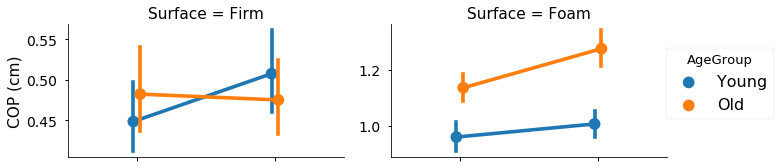

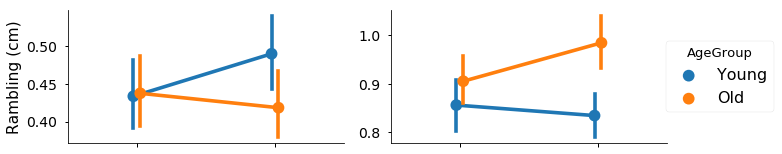

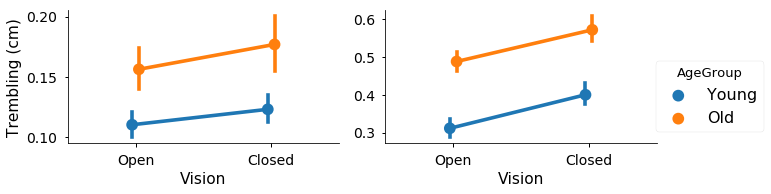

In [23]:
plot_summary(BDSinfo)

## The COP-COGv decomposition

It's possible to estimate the COG vertical projection (COGv or GL) from the COP displacement based on the inverted-pendulum model of the body on quiet standing.  

See the notebook [The inverted pendulum model of the human standing posture](http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/IP_Model.ipynb)

Let's do some analysis with that.

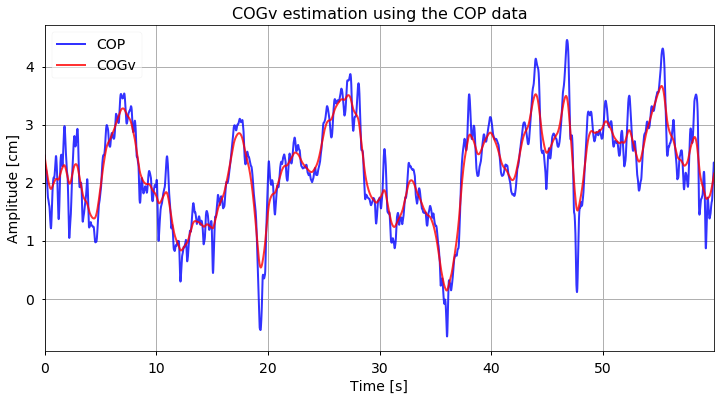

In [24]:
from cogve import cogve

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
cogv = cogve(COPx2, freq=100, mass=np.mean(Fz)/10, height=170, ax=ax, show=True)
cop_cogv = COPx2 - cogv

### Let's run the COP-COGv decomposition for the same subjects:

In [25]:
fname = os.path.join(path2, 'BDSinfo.txt')
BDSinfo = pd.read_csv(fname, sep='\t', header=0, index_col=None, engine='c', encoding='utf-8')
print("Information of %s subjects loaded (%s rows, %s columns)."
      %(len(pd.unique(BDSinfo.Subject)), BDSinfo.shape[0], BDSinfo.shape[1]))
display(BDSinfo.drop_duplicates(subset='Subject')[['AgeGroup', 'Subject']].groupby(['AgeGroup']).count())
#BDSinfo = BDSinfo.loc[BDSinfo.Disability=='No']  # uncomment this line
print('After selection: %s subjects.' %len(pd.unique(BDSinfo.Subject)))

Information of 163 subjects loaded (1930 rows, 64 columns).


,Subject
AgeGroup,
Old,76
Young,87


After selection: 163 subjects.


In [26]:
fp = FloatProgress(min=0, max=len(BDSinfo.Trial)-1)
display(fp)
freq = 100
for i, fname in enumerate(BDSinfo.Trial):
    filename = os.path.join(path2, fname + '.txt')
    fp.description = 'Reading data from file %s (%s/%s)/n' %(os.path.basename(filename), i+1, len(BDSinfo.Trial))
    fp.value = i
    grf = pd.read_csv(filename, delimiter='\t', skiprows=1, header=None,
                      names=['Time','Fx','Fy','Fz','Mx','My','Mz','COPx','COPy'], engine='c')   
    t, Fx, Fy, Fz, Mx, My, Mz, COPx, COPy = [_ for _ in grf.values.T]
    # COP-COGv decomposition:
    t2 = t[inds0[0]:inds0[-1]+1]
    Fx2 = Fx[inds0[0]:inds0[-1]+1] - np.mean(Fx)
    COPx2 = COPx[inds0[0]:inds0[-1]+1]
    # calculate some summary statistics of the trajectories:
    cogv = cogve(COPx2, freq=100, mass=np.mean(Fz)/10, height=170, ax=ax, show=False)
    copcogv = COPx2 - cogv
    COPsd, COGVsd, COPCOGVsd = np.std(COPx2), np.std(cogv), np.std(copcogv)
    BDSinfo.loc[i, 'COP2_sd'] = COPsd
    BDSinfo.loc[i, 'COGv_sd'] = COGVsd
    BDSinfo.loc[i, 'COPCOGv_sd'] = COPCOGVsd
    
BDSinfo.to_csv(os.path.join(path2, 'BDSinfoCOPCOGv.txt'), sep='\t', encoding='utf-8', index=False)
print('Data from %d files were processed.' %len(BDSinfo.Trial))

FloatProgress(value=0.0, max=1929.0)

Data from 1930 files were processed.


In [27]:
def plot_summary2(data):
    g0 = sns.factorplot(x='Vision', y='COP2_sd', hue='AgeGroup', order=['Open', 'Closed'],
                        data=data, estimator=np.mean, ci=95, col='Surface',
                        kind='point', dodge=True, sharey=False, size=3, aspect=1.6)
    g0.set_xticklabels(''), g0.set_axis_labels('', 'COP (cm)')
    g1 = sns.factorplot(x='Vision', y='COGv_sd', hue='AgeGroup', order=['Open', 'Closed'],
                        data=data, estimator=np.mean, ci=95, col='Surface',
                        kind='point', dodge=True, sharey=False, size=3, aspect=1.6)
    g1.set_axis_labels('', 'COGv (cm)')
    g1.set_titles('',''), g1.set_xticklabels('')
    g2 = sns.factorplot(x='Vision', y='COPCOGv_sd', hue='AgeGroup', order=['Open', 'Closed'],
                        data=data, estimator=np.mean, ci=95, col='Surface',
                        kind='point', dodge=True, sharey=False, size=3, aspect=1.6)
    g2.set_axis_labels('Vision', 'COP-COGv (cm)'), g2.set_titles('','')
    plt.show()

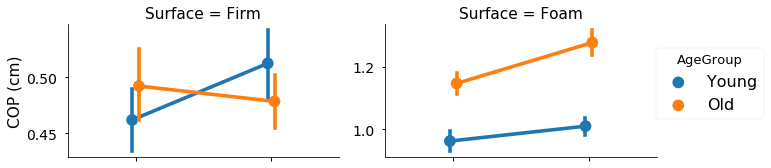

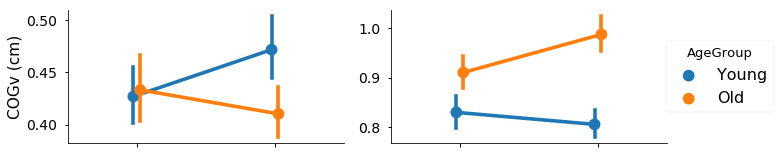

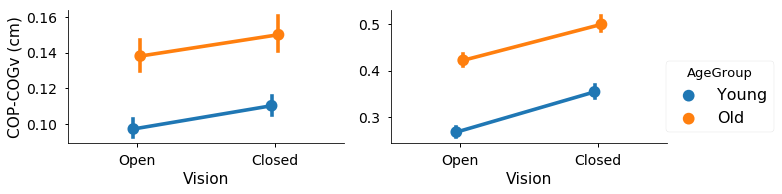

In [28]:
plot_summary2(BDSinfo)

## References

- Gurfinkel et al. (1995) Kinesthetic reference for human orthograde posture. Neuroscience, 68, 229.  
- Santos DA, Duarte M. (2016) A public data set of human balance evaluations. PeerJ4:e2648 https://doi.org/10.7717/peerj.2648.  
- Zatsiorsky VM, Duarte M (1999) Instant equilibrium point and its migration in standing tasks: Rambling and trembling components of the stabilogram. Motor Control, 3, 28. [PDF](http://demotu.org/pubs/mc99.pdf).  
- Zatsiorsky VM, Duarte M (2000) Rambling and trembling in quiet standing. Motor Control, 2, 185. [PDF](http://demotu.org/pubs/e00.pdf).  

# Obrigado